# The 30 Degree Rule

## Intro

The 30 degree rule states that the cue ball, when colliding with a ball over a wide range of cut angles, will be deflected roughly 30 degrees from it's initial course after the collision. It is more of a *rule of thumb* used by pool players to improve their game, rather than a truism of pool physics.

In this example, we will setup simulations that test the 30 degree rule and some of the physics equations defined by [Dr. Dave Billiards](https://drdavebilliards.com/).

## Assumptions

We'll use one of pooltool's simpler ball-ball models which assumes perfectly elastic and frictionless ball-ball collisions. Read more [here](https://ekiefl.github.io/2020/04/24/pooltool-theory/#section-ii-ball-ball-interactions).

Importantly, the cue ball must be rolling (without slippage) when it contacts the object ball. Otherwise, the 30-degree rule will not hold. As an extreme example of this, a cue ball with no spin will deflect off the object ball along the [tangent line](https://billiards.colostate.edu/faq/stun/90-degree-rule/).

## Definitions

**The rule, stated in full:**

> The 30° rule states that for a rolling cue ball (CB) shot, over a wide range of cut angles, between a 1/4-ball hit (49 degree cut) and 3/4-ball hit (14 degree cut), the CB will deflect or carom off by very close to 30° (the “natural angle“) from its original direction after hitting the object ball (OB). If you want to be more precise, the angle is a little more (about 34°) closer to a 1/2-ball hit and a little less (about 27°) closer to a 1/4-ball or 3/4-ball hit.

*(source: [https://billiards.colostate.edu/faq/30-90-rules/30-degree-rule/](https://billiards.colostate.edu/faq/30-90-rules/30-degree-rule/))*

**The carom angle**

The carom angle is the angle that the rule claims is 30 degrees. Formally, it is the angle between the velocity of the cue ball directly before impact, and the velocity of the cue ball after the collision once the cue ball is no longer sliding on the cloth. We will see that this angle is independent of the cue's initial speed.

**Ball-hit fraction and cut angle**

- Ball-hit fraction, $f$, describes the fraction of overlap between the cue ball and object ball, projected in the direction of the aiming line.
- Cut angle, $\phi$, refers to the angle that the cue ball glances the object ball, where $0$ refers to a full ball hit (straight on), and $90$ refers to the lower bound of the thinnest hit possible.

These two are visualized in this diagram, where $f = \text{ball overlap} / (2R)$:

<img src="assets/30_degree_rule/diagram1.png" width="500px" />

*(source: [https://billiards.colostate.edu/technical_proofs/new/TP_A-23.pdf](https://billiards.colostate.edu/technical_proofs/new/TP_A-23.pdf))*

Establishing the relationship between these quantities is important, since the 30 degree rule makes reference to both cut angle and ball-hit fraction. One can calculate the ball-hit fraction from cut angle with the following equation:

$$
f(\phi) = 1 - \sin{\phi}
$$

## Simulating a collision

To start, we'll need to create a billiards system. That means defining a table, a cue stick, and a collection of balls.

We'll start with a table. Since we don't want collisions with cushions to interfere with our trajectory, let's make an unrealistically large $10\text{m} \times 10\text{m}$  [Table](../autoapi/pooltool/index.rst#pooltool.Table).

In [1]:
import pooltool as pt

table_specs = pt.objects.BilliardTableSpecs(l=10, w=10)
table = pt.Table.from_table_specs(table_specs)

Next, we'll create two [Ball](../autoapi/pooltool/index.rst#pooltool.Ball) objects.

In [2]:
cue_ball = pt.Ball.create("cue", xy=(2.5, 1.5))
obj_ball = pt.Ball.create("obj", xy=(2.5, 3.0))

Next, we'll need a [Cue](../autoapi/pooltool/index.rst#pooltool.Cue).

In [3]:
cue = pt.Cue(cue_ball_id="cue")

Finally, we'll need to wrap these objects up into a [System](../autoapi/pooltool/index.rst#pooltool.System). We'll call this our system *template*, with the intention of reusing it for many different shots.

In [4]:
system_template = pt.System(
    table=table,
    cue=cue,
    balls=(cue_ball, obj_ball),
)

Let's set up a shot by aiming at the object ball with a cut angle of 30 degrees. There is a small clash in terminology here, because in pooltool, `phi` is an angle defined with respect to the table, not the cut angle:

<img src="https://ekiefl.github.io/images/pooltool/pooltool-theory/table_coordinates.jpg" width="130px" />

So in the function call below, `pt.aim.at_ball(system, "obj", cut=30)` returns the angle `phi` that the cue ball should be directed at such that a cut angle of 30 degrees with the object ball is achieved.

In [5]:
# Creates a deep copy of the template
system = system_template.copy()

phi = pt.aim.at_ball(system, "obj", cut=30)
system.cue.set_state(V0=3, phi=phi, b=0.4)

Now, we [simulate](../autoapi/pooltool/index.rst#pooltool.simulate) the shot and then [continuize](../autoapi/pooltool/evolution/continuize/index.html#pooltool.evolution.continuize.continuize) it to store ball state data (like coordinates) in $10\text{ms}$ timestep intervals.

In [6]:
# Create a default physics engine, then overwrite ball-ball model with frictionless, elastic model.
engine = pt.physics.PhysicsEngine()
engine.resolver.ball_ball = pt.physics.ball_ball_models[pt.physics.BallBallModel.FRICTIONLESS_ELASTIC]()

pt.simulate(system, engine=engine, inplace=True)
pt.continuize(system, dt=0.01, inplace=True)

print(f"System simulated: {system.simulated}")

System simulated: True


## Visualizing the collision

If you have a graphics card, you can immediately visualize this shot in 3D with

```python
pt.show(system)
```

Since that can't be embedded into the documentation, we'll instead plot the trajectory of the cue ball and object ball by accessing ther historical states.

In [7]:
cue_ball = system.balls["cue"]
obj_ball = system.balls["obj"]
cue_history = cue_ball.history_cts
obj_history = obj_ball.history_cts
type(cue_history)

pooltool.objects.ball.datatypes.BallHistory

The [BallHistory](../autoapi/pooltool/objects/index.rst#pooltool.objects.BallHistory) holds the ball's historical states, each stored as a [BallState](../autoapi/pooltool/objects/index.rst#pooltool.objects.BallState) object. Each attribute of the ball states can be concatenated into numpy arrays with the [BallHistory.vectorize](../autoapi/pooltool/objects/index.rst#pooltool.objects.BallHistory.vectorize) method.

In [8]:
rvw_cue, s_cue, t_cue = cue_history.vectorize()
rvw_obj, s_obj, t_obj = obj_history.vectorize()

print(rvw_cue.shape)
print(s_cue.shape)
print(t_cue.shape)

(1352, 3, 3)
(1352,)
(1352,)


We can grab the xy-coordinates from the `rvw` array by with the following.

In [9]:
coords_cue = rvw_cue[:, 0, :2]
coords_obj = rvw_obj[:, 0, :2]
coords_cue.shape

(1352, 2)

In [10]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "sphinx_gallery"

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=coords_cue[:, 0], y=coords_cue[:, 1], mode="lines", name="cue")
)
fig.add_trace(
    go.Scatter(x=coords_obj[:, 0], y=coords_obj[:, 1], mode="lines", name="obj")
)
fig.update_layout(
    title="Ball trajectories",
    xaxis_title="X [m]",
    yaxis_title="Y [m]",
    yaxis_scaleanchor="x",
    yaxis_scaleratio=1,
    width=600,
    template="presentation",
)

fig.show()

## Calculating the carom angle

One could calculate the carom angle for the above trajectory by manually splicing the trajectory coordinates of the cue ball and determining ball direction by comparing temporally adjacent coordinates. However, pooltool has much more precise methods for dissecting shot dynamics.

As mentioned before, the carom angle is the angle between the cue ball velocity right before collision, and the cue ball velocity post-collision, once the ball has stopped sliding on the cloth. Hidden somewhere in the system **event list** one can find the events corresponding to these precise moments in time:

In [11]:
system.events[:6]

  ├── type   : none
  ├── time   : 0
  └── agents : ('dummy',),
  ├── type   : stick_ball
  ├── time   : 0
  └── agents : ('cue_stick', 'cue'),
  ├── type   : sliding_rolling
  ├── time   : 6.467004657784513e-17
  └── agents : ('cue',),
  ├── type   : ball_ball
  ├── time   : 0.4132706782912061
  └── agents : ('cue', 'obj'),
  ├── type   : sliding_rolling
  ├── time   : 0.8533126707158925
  └── agents : ('obj',),
  ├── type   : sliding_rolling
  ├── time   : 0.8533126707158927
  └── agents : ('cue',)]

Programatically, we can pick out these two events of interest with event selection syntax.

Since there is only one ball-ball collision, it's easy to select with [filter_type](../autoapi/pooltool/events/index.rst#pooltool.events.filter_type):

In [12]:
collision = pt.events.filter_type(system.events, pt.EventType.BALL_BALL)[0]
collision

 ├── type   : ball_ball
 ├── time   : 0.4132706782912061
 └── agents : ('cue', 'obj')

To get the event when the cue ball stops sliding, we can similarly try filtering by the sliding to rolling transition event:

In [13]:
pt.events.filter_type(system.events, pt.EventType.SLIDING_ROLLING)

  ├── type   : sliding_rolling
  ├── time   : 6.467004657784513e-17
  └── agents : ('cue',),
  ├── type   : sliding_rolling
  ├── time   : 0.8533126707158925
  └── agents : ('obj',),
  ├── type   : sliding_rolling
  ├── time   : 0.8533126707158927
  └── agents : ('cue',),
  ├── type   : sliding_rolling
  ├── time   : 2.9537094941822026
  └── agents : ('obj',),
  ├── type   : sliding_rolling
  ├── time   : 4.841243735194121
  └── agents : ('obj',),
  ├── type   : sliding_rolling
  ├── time   : 5.628109523804255
  └── agents : ('cue',),
  ├── type   : sliding_rolling
  ├── time   : 11.98683196671916
  └── agents : ('cue',)]

But there are many sliding to rolling transition events, and to make matters worse, they are shared by both the cue ball and the object ball. What we need is the **first** **sliding to rolling** transition that the **cue ball** undergoes **after** the **ball-ball** collision. We can achieve this multi-criteria query with [filter_events](../autoapi/pooltool/events/index.rst#pooltool.events.filter_events):

In [14]:
transition = pt.events.filter_events(
    system.events,
    pt.events.by_time(t=collision.time, after=True),
    pt.events.by_ball("cue"),
    pt.events.by_type(pt.EventType.SLIDING_ROLLING),
)[0]
transition

 ├── type   : sliding_rolling
 ├── time   : 0.8533126707158927
 └── agents : ('cue',)

Now, we can dive into these two events and pull out the cue ball velocities we need to calculate the carom angle.

In [15]:
# Velocity prior to impact
velocity_initial = collision.get_ball("cue", initial=True).vel[:2]

# Velocity post sliding
# We choose the "final" here for posterity, but the velocity is the same both before and after resolving the transition.
velocity_final = transition.get_ball("cue", initial=False).vel[:2]

carom_angle = pt.ptmath.utils.angle_between_vectors(velocity_final, velocity_initial)

print(f"The carom angle is {carom_angle:.1f} degrees")

The carom angle is 33.7 degrees


## Carom angle as a function of cut angle

We calculated the carom angle for a single cut angle, 30 degrees. Let's write a function called `get_carom_angle` so we can do that repeatedly for different cut angles.

In [16]:
def get_carom_angle(system: pt.System) -> float:
    assert system.simulated

    collision = pt.events.filter_type(system.events, pt.EventType.BALL_BALL)[0]
    transition = pt.events.filter_events(
        system.events,
        pt.events.by_time(t=collision.time, after=True),
        pt.events.by_ball("cue"),
        pt.events.by_type(pt.EventType.SLIDING_ROLLING),
    )[0]

    velocity_final = transition.get_ball("cue", initial=False).state.rvw[1, :2]
    velocity_initial = collision.get_ball("cue", initial=True).state.rvw[1, :2]

    return pt.ptmath.utils.angle_between_vectors(velocity_final, velocity_initial)

`get_carom_angle` assumes the passed system has already been simulated, so we'll need another function to take care of that. We'll cue stick speed and cut angle as parameters.

In [17]:
def simulate_experiment(V0: float, cut_angle: float) -> pt.System:
    system = system_template.copy()
    phi = pt.aim.at_ball(system, "obj", cut=cut_angle)
    system.cue.set_state(V0=V0, phi=phi, b=0.4)
    pt.simulate(system, engine=engine, inplace=True)
    return system

We'll also want the ball hit fraction:

In [18]:
import numpy as np

def get_ball_hit_fraction(cut_angle: float) -> float:
    return 1 - np.sin(cut_angle * np.pi / 180)

With these functions, we are ready to simulate how carom angle varies as a function of cut angle.

In [19]:
import pandas as pd

data = {
    "phi": [],
    "f": [],
    "theta": [],
}

V0 = 2.5

for cut_angle in np.linspace(2, 88, 50):
    print(f"{cut_angle=}")
    system = simulate_experiment(V0, cut_angle)
    data["theta"].append(get_carom_angle(system))
    data["f"].append(get_ball_hit_fraction(cut_angle))
    data["phi"].append(cut_angle)

frame = pd.DataFrame(data)
frame.head(10)

cut_angle=np.float64(2.0)
cut_angle=np.float64(3.7551020408163263)
cut_angle=np.float64(5.5102040816326525)
cut_angle=np.float64(7.26530612244898)
cut_angle=np.float64(9.020408163265305)
cut_angle=np.float64(10.775510204081632)
cut_angle=np.float64(12.53061224489796)
cut_angle=np.float64(14.285714285714285)
cut_angle=np.float64(16.04081632653061)
cut_angle=np.float64(17.79591836734694)
cut_angle=np.float64(19.551020408163264)
cut_angle=np.float64(21.30612244897959)
cut_angle=np.float64(23.06122448979592)
cut_angle=np.float64(24.816326530612244)
cut_angle=np.float64(26.57142857142857)
cut_angle=np.float64(28.3265306122449)
cut_angle=np.float64(30.081632653061224)
cut_angle=np.float64(31.83673469387755)
cut_angle=np.float64(33.59183673469388)
cut_angle=np.float64(35.3469387755102)
cut_angle=np.float64(37.10204081632653)
cut_angle=np.float64(38.857142857142854)
cut_angle=np.float64(40.61224489795918)
cut_angle=np.float64(42.36734693877551)
cut_angle=np.float64(44.12244897959184)
cut_angle

,phi,f,theta
0,2.000000,0.965101,4.971244
1,3.755102,0.934508,9.208701
2,5.510204,0.903977,13.139984
3,7.265306,0.873536,16.757206
4,9.020408,0.843214,20.060728
5,10.775510,0.813039,22.879233
6,12.530612,0.783039,25.358318
7,14.285714,0.753243,27.429965
8,16.040816,0.723678,29.132091
9,17.795918,0.694373,30.525388


From this dataframe we can make some plots. On top of the ball-hit fraction, plot, I'll create a box between a $1/4$ ball hit and a $3/4$ ball hit, since this is the carom angle range that the 30-degree rule is defined with respect to.

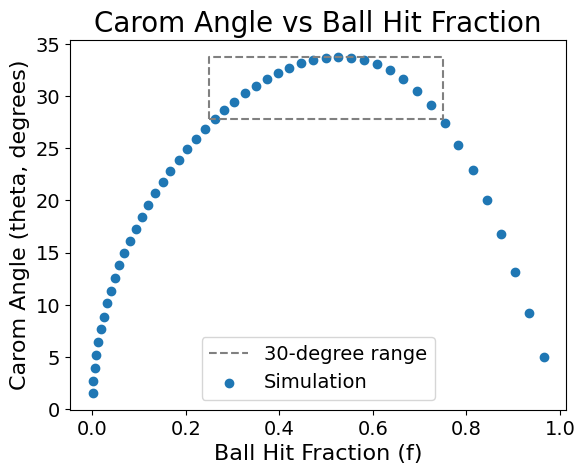

In [20]:
import matplotlib.pyplot as plt

x_min = 0.25
x_max = 0.75
y_min = frame.loc[(frame.f >= x_min) & (frame.f <= x_max), "theta"].min()
y_max = frame.loc[(frame.f >= x_min) & (frame.f <= x_max), "theta"].max()
box_data_x = [x_min, x_min, x_max, x_max, x_min]
box_data_y = [y_min, y_max, y_max, y_min, y_min]

fig, ax = plt.subplots()
ax.plot(box_data_x, box_data_y, linestyle='--', color='gray', label='30-degree range')
ax.scatter(frame['f'], frame['theta'], color='#1f77b4', label='Simulation')
ax.set_title('Carom Angle vs Ball Hit Fraction', fontsize=20)
ax.set_xlabel('Ball Hit Fraction (f)', fontsize=16)
ax.set_ylabel('Carom Angle (theta, degrees)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
plt.show()

Between a $1/4$ and $3/4$ ball hit, there is a relative invariance in the carom angle, with a range of around 6 degrees.

For your reference, here is the same plot but with cut angle $\phi$ as the x-axis:

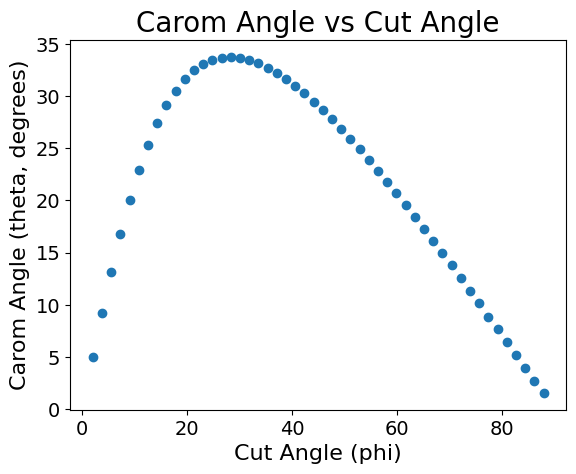

In [21]:
fig, ax = plt.subplots()
ax.scatter(frame['phi'], frame['theta'], color='#1f77b4')
ax.set_title('Carom Angle vs Cut Angle', fontsize=20)
ax.set_xlabel('Cut Angle (phi)', fontsize=16)
ax.set_ylabel('Carom Angle (theta, degrees)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

## Comparison to theory

Under the assumption of a perfectly elastic and frictionless ball-ball collision, Dr. Dave has calculated the theoretical carom angle $\theta$ to be

$$
\theta_{\text{ideal}}(\phi) = \arctan{\frac{\sin\phi \times \cos\phi}{\sin^2\phi + \frac{2}{5}}}
$$

*(source: [https://billiards.colostate.edu/technical_proofs/new/TP_B-13.pdf](https://billiards.colostate.edu/technical_proofs/new/TP_B-13.pdf))*

Since pooltool's baseline physics engine makes the same assumptions, we should expect the results to be the same. Let's directly compare:

In [22]:
def get_theoretical_carom_angle(phi) -> float:
    return np.atan2(np.sin(phi) * np.cos(phi), (np.sin(phi) ** 2 + 2 / 5))

phi_theory = np.linspace(0, np.pi / 2, 500)
theta_theory = get_theoretical_carom_angle(phi_theory)

phi_theory *= 180 / np.pi
theta_theory *= 180 / np.pi
f_theory = get_ball_hit_fraction(phi_theory)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=box_data_x,
        y=box_data_y,
        mode="lines",
        name="30-degree range",
        line=dict(dash="dash", color="gray"),
    )
)
fig.add_trace(
    go.Scatter(
        x=frame["f"],
        y=frame["theta"],
        mode="markers",
        name="Simulation",
        marker=dict(color="#1f77b4"),
    )
)
fig.add_trace(go.Scatter(x=f_theory, y=theta_theory, mode="lines", name="Theory"))
fig.update_layout(
    title="Carom Angle vs Ball Hit Fraction",
    xaxis_title="Ball Hit Fraction (f)",
    yaxis_title="Carom Angle (theta, degrees)",
    template="presentation",
)
fig.show()

A perfect match.

## Impact speed independence

Interestingly, the carom angle is independent of the speed:

In [23]:
for V0 in np.linspace(1, 4, 20):
    system = simulate_experiment(V0, 30)
    carom_angle = get_carom_angle(system)
    print(f"Carom angle for V0={V0:2f} is {carom_angle:4f}")

Carom angle for V0=1.000000 is 33.671326
Carom angle for V0=1.157895 is 33.671326
Carom angle for V0=1.315789 is 33.671326
Carom angle for V0=1.473684 is 33.671326
Carom angle for V0=1.631579 is 33.671326
Carom angle for V0=1.789474 is 33.671326
Carom angle for V0=1.947368 is 33.671326
Carom angle for V0=2.105263 is 33.671326
Carom angle for V0=2.263158 is 33.671326
Carom angle for V0=2.421053 is 33.671326
Carom angle for V0=2.578947 is 33.671326
Carom angle for V0=2.736842 is 33.671326
Carom angle for V0=2.894737 is 33.671326
Carom angle for V0=3.052632 is 33.671326
Carom angle for V0=3.210526 is 33.671326
Carom angle for V0=3.368421 is 33.671326
Carom angle for V0=3.526316 is 33.671326
Carom angle for V0=3.684211 is 33.671326
Carom angle for V0=3.842105 is 33.671326
Carom angle for V0=4.000000 is 33.671326


This doesn't mean that the trajectories are the same though. Here are the trajectories:

In [24]:
import numpy as np
import plotly.graph_objects as go


def get_coordinates(system: pt.System):
    rvw, s, t = system.balls["cue"].history_cts.vectorize()
    xy = rvw[:, 0, :2]

    return xy, s, t


fig = go.Figure()

for V0 in np.linspace(1, 3, 6):
    system = simulate_experiment(V0, 30)
    pt.continuize(system, dt=0.03, inplace=True)
    rvw, s, t = system.balls["cue"].history_cts.vectorize()
    xy = rvw[:, 0, :2]

    fig.add_trace(
        go.Scatter(
            x=xy[:, 0],
            y=xy[:, 1],
            mode="lines",
            name=f"Speed {V0}",
            showlegend=True,
        )
    )

fig.update_layout(
    title="Ball trajectories",
    xaxis_title="X [m]",
    yaxis_title="Y [m]",
    yaxis_scaleanchor="x",
    yaxis_scaleratio=1,
    width=600,
    xaxis=dict(range=[1.5, 4.5]),
    yaxis=dict(range=[1.5, 4.5]),
    template="presentation",
)
fig.show()

Harder shots follow the *tangent line* (aka the line perpendicular to the line connected the balls' centers during contact) for longer, but they all converge to the same outgoing angle.